In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as layers


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2023-psl-week-using-bloomberg-news/train.csv
/kaggle/input/2023-psl-week-using-bloomberg-news/test.csv


# Load dataset

In [2]:
filepath = "/kaggle/input/2023-psl-week-using-bloomberg-news/train.csv"

dataset = pd.read_csv(filepath)

In [3]:
dataset.head()

,Unnamed: 0,positive,negative,indecisive,score,y
0,2010-01-04,11.0,3.0,0.0,0.571429,0.043956
1,2010-01-05,6.0,6.0,3.0,0.000000,0.042511
2,2010-01-06,7.0,3.0,1.0,0.400000,0.041065
3,2010-01-07,9.0,5.0,0.0,0.285714,0.034180
4,2010-01-08,7.0,3.0,2.0,0.400000,0.049178


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594 entries, 0 to 2593
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2594 non-null   object 
 1   positive    2594 non-null   float64
 2   negative    2594 non-null   float64
 3   indecisive  2594 non-null   float64
 4   score       2594 non-null   float64
 5   y           2594 non-null   float64
dtypes: float64(5), object(1)
memory usage: 121.7+ KB


In [5]:
dataset['sum'] = dataset['positive'] + dataset['negative'] + dataset['indecisive']
dataset.head(5)

,Unnamed: 0,positive,negative,indecisive,score,y,sum
0,2010-01-04,11.0,3.0,0.0,0.571429,0.043956,14.0
1,2010-01-05,6.0,6.0,3.0,0.000000,0.042511,15.0
2,2010-01-06,7.0,3.0,1.0,0.400000,0.041065,11.0
3,2010-01-07,9.0,5.0,0.0,0.285714,0.034180,14.0
4,2010-01-08,7.0,3.0,2.0,0.400000,0.049178,12.0


In [6]:
# plt.plot(dataset['Unnamed: 0'], dataset['positive'])
# plt.plot(dataset['Unnamed: 0'], dataset['negative'])
# plt.plot(dataset['Unnamed: 0'], dataset['indecisive'])

In [7]:
dataset.describe()

,positive,negative,indecisive,score,y,sum
count,2594.000000,2594.000000,2594.000000,2594.000000,2594.000000,2594.000000
mean,5.520432,5.919429,2.308019,-0.036421,0.038795,13.747880
std,2.963424,2.966854,1.823159,0.473590,0.064975,1.238462
min,0.000000,0.000000,0.000000,-1.000000,-0.234264,6.000000
25%,3.000000,4.000000,1.000000,-0.400000,0.003406,13.000000
50%,5.000000,6.000000,2.000000,0.000000,0.042638,14.000000
75%,8.000000,8.000000,3.000000,0.333333,0.081637,15.000000
max,14.000000,14.000000,10.000000,1.000000,0.254303,15.000000


# Prepare dataset

In [8]:
# dataset['Unnamed: 0'] = pd.to_datetime(dataset['Unnamed: 0'])
# dataset = dataset.set_index('Unnamed: 0')

In [9]:
# from sklearn.preprocessing import MinMaxScaler

# # Assuming 'Date' is a column in your dataset
# dataset['Timestamp'] = (dataset['Unnamed: 0'] - pd.Timestamp("Y")).dt.total_seconds()
# scaler = MinMaxScaler()
# dataset['Timestamp'] = scaler.fit_transform(dataset[['Timestamp']])

In [10]:
# try normalising each data point with the sum

In [11]:
dataset['positive'] = dataset['positive'] / dataset['sum']
dataset['negative'] = dataset['negative'] / dataset['sum']
dataset['indecisive'] = dataset['indecisive'] / dataset['sum']

In [12]:
dataset_sum = dataset.pop('sum')
y = dataset.pop('y')
x = dataset
dates = x.pop('Unnamed: 0')


In [13]:
x.head()

,positive,negative,indecisive,score
0,0.785714,0.214286,0.000000,0.571429
1,0.400000,0.400000,0.200000,0.000000
2,0.636364,0.272727,0.090909,0.400000
3,0.642857,0.357143,0.000000,0.285714
4,0.583333,0.250000,0.166667,0.400000


In [14]:
y.head()

0    0.043956
1    0.042511
2    0.041065
3    0.034180
4    0.049178
Name: y, dtype: float64

# Define model

In [15]:
features = 1 # 1D data
input_shape = x.shape[1]

model = tf.keras.models.Sequential([
    layers.LSTM(units=128, input_shape=(input_shape, features), return_sequences=True),
    layers.LSTM(units=64, input_shape=(input_shape, features)),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=4, activation='relu'),
    layers.Dense(units=2, activation='relu'),
    layers.Dense(units=1)
])

loss_function = tf.keras.losses.MeanAbsoluteError()
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001) # changed lr from 0.001
model.compile(loss = loss_function, optimizer=optimiser, metrics=['mae'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 1

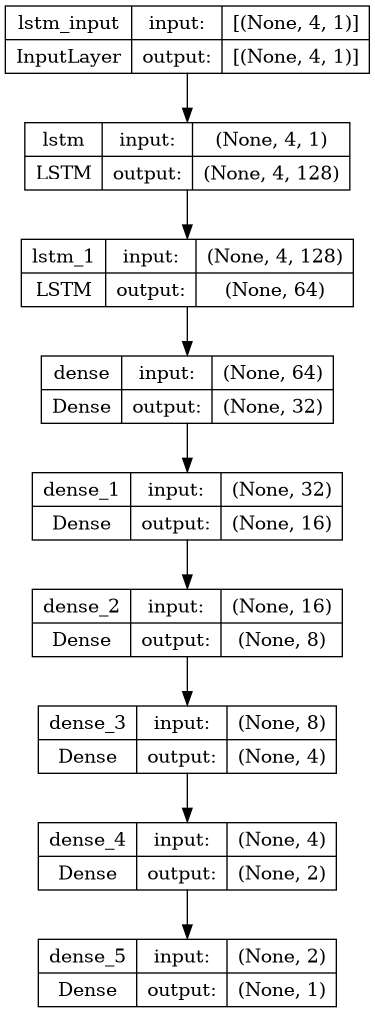

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Test dataset

In [18]:
model.fit(x, y, epochs=50, batch_size=32)

Epoch 1/50
82/82 [==============================] - 6s 11ms/step - loss: 0.0602 - mae: 0.0602
Epoch 2/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0569 - mae: 0.0569
Epoch 3/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0544 - mae: 0.0544
Epoch 4/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0526 - mae: 0.0526
Epoch 5/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0514 - mae: 0.0514
Epoch 6/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0507 - mae: 0.0507
Epoch 7/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0504 - mae: 0.0504
Epoch 8/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0501 - mae: 0.0501
Epoch 9/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0500 - mae: 0.0500
Epoch 10/50
82/82 [==============================] - 1s 10ms/step - loss: 0.0500 - mae: 0.0500
Epoch 11/50
82/82 [==============================] - 1s 10m

# Generate submission

In [19]:
test_dataset = pd.read_csv("/kaggle/input/2023-psl-week-using-bloomberg-news/test.csv")
dates = test_dataset.pop('Unnamed: 0')

In [20]:
test_dataset['sum'] = test_dataset['positive'] + test_dataset['negative'] + test_dataset['indecisive']

test_dataset['positive'] = test_dataset['positive'] / test_dataset['sum']
test_dataset['negative'] = test_dataset['negative'] / test_dataset['sum']
test_dataset['indecisive'] = test_dataset['indecisive'] / test_dataset['sum']

test_dataset_sum = test_dataset.pop('sum')

In [21]:
test_dataset.head()

,positive,negative,indecisive,score
0,0.583333,0.250000,0.166667,0.400000
1,0.071429,0.785714,0.142857,-0.833333
2,0.500000,0.357143,0.142857,0.166667
3,0.357143,0.428571,0.214286,-0.090909
4,0.642857,0.214286,0.142857,0.500000


In [22]:
predictions = model.predict(test_dataset)

30/30 [==============================] - 1s 4ms/step


In [23]:
submission = pd.DataFrame()
submission['date'] = dates
submission['y'] = predictions

In [24]:
submission.head()

,date,y
0,2020-01-02,0.042982
1,2020-01-03,0.042982
2,2020-01-06,0.042982
3,2020-01-07,0.042982
4,2020-01-08,0.042982


In [25]:
submission.describe()

,y
count,957.000000
mean,0.042982
std,0.000000
min,0.042982
25%,0.042982
50%,0.042982
75%,0.042982
max,0.042982


In [26]:
submission.to_csv('/kaggle/working/submission.csv',index=False,header=True)